In [ ]:
# pip install keras-tuner

In [ ]:
#importing necessary libraries

import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Flatten

# from prophet import Prophet

#DATASET ANALYSIS

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Numerical Dataset Curation/Meteorological_Data.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8888 entries, 0 to 8887
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   DATETIME                             8888 non-null   object 
 1   Avg BRBG Total Cloud Cover [%]       8888 non-null   float64
 2   Avg CDOC Total Cloud Cover [%]       8888 non-null   float64
 3   Avg CDOC Thick Cloud Cover [%]       8888 non-null   float64
 4   Avg CDOC Thin Cloud Cover [%]        8888 non-null   float64
 5   Avg Sun Flag                         8888 non-null   float64
 6   Avg HCF Value                        8888 non-null   float64
 7   Avg Blue/Red_min                     8888 non-null   float64
 8   Avg Blue/Red_mid                     8888 non-null   float64
 9   Avg Blue/Red_max                     8888 non-null   float64
 10  Avg File Extension                   8888 non-null   float64
 11  Avg Global CMP22 (vent/cor) [W

#PREPROCESSING

In [ ]:
def preprocess_dataframe(df):
  """
  params:
  - df (dataframe): dataframe before preprocessing
  does:
  - Transform 'DATETIME' column from object to datetime format with renaming of column to timestamp.
  - Remove Outliers
  -Timestamp can be changed to index
  returns: Processed df (dataframe)
  """
  df['Timestamp'] = pd.to_datetime(df['DATETIME'])
  # df.set_index('Timestamp', inplace=True) # set timestamp as index

  df=df.drop(['DATETIME', 'Avg Solar Eclipse Shading'], axis=1) # Remove null columns
  df = df[df["Avg CDOC Total Cloud Cover [%]"] !=-99999 ] # remove outliers
  return df

In [ ]:
def create_timestamp_features(df,lag_order=1):
    """
    Create timestamp features from a DataFrame.

    Parameters:
    - df (dataframe): DataFrame with a 'DATETIME' column.
    - lag_order (int): Number of lags for the target variable (default is 1).

    Returns:
    - DataFrame with additional timestamp features.
    """
    # Extract timestamp features
    df['hour_of_day'] = df['Timestamp'].dt.hour
    df['day_of_year'] = df['Timestamp'].dt.dayofyear
    df['month'] = df['Timestamp'].dt.month

    # Calculate lagged values for the target variable
    target_column = 'Avg Global CMP22 (vent/cor) [W/m^2]'
    for lag in range(1, lag_order + 1):
        df[f'{target_column}_lagged_{lag}'] = df[target_column].shift(lag).fillna(0)


    df.set_index('Timestamp', inplace=True) # set timestamp as index

    return df


In [ ]:
df=preprocess_dataframe(data)

### Selecting Features based on Feature Selection and Modeling

In [ ]:
cols_to_keep = ['Avg Zenith Angle [degrees]','Avg Sun Flag','Avg Opaque Cloud Cover [%]','Avg Blue/Red_min','Avg Global CMP22 (vent/cor) [W/m^2]','Avg BRBG Total Cloud Cover [%]','Avg Azimuth Angle [degrees]','Avg Albedo (CMP11)','Avg Tower Dew Point Temp [deg C]','Avg Total Cloud Cover [%]','Timestamp']
data_df=df.loc[:, cols_to_keep]

data_df = create_timestamp_features(data_df)
data_df.head(10)

,Avg Zenith Angle [degrees],Avg Sun Flag,Avg Opaque Cloud Cover [%],Avg Blue/Red_min,Avg Global CMP22 (vent/cor) [W/m^2],Avg BRBG Total Cloud Cover [%],Avg Azimuth Angle [degrees],Avg Albedo (CMP11),Avg Tower Dew Point Temp [deg C],Avg Total Cloud Cover [%],hour_of_day,day_of_year,month,Avg Global CMP22 (vent/cor) [W/m^2]_lagged_1
Timestamp,,,,,,,,,,,,,,
2021-10-08 07:00:00,85.6866,8.0,10.4667,0.9617,63.8407,13.6667,101.5014,0.2815,-1.1220,19.9667,7,281,10,0.0000
2021-10-08 08:00:00,74.7881,3.5,47.8667,0.9333,176.1522,56.1667,111.7340,0.2330,-1.0662,61.8333,8,281,10,63.8407
2021-10-08 09:00:00,64.6156,3.0,77.2333,0.9267,361.7695,73.0000,123.3821,0.2085,-0.2234,91.6167,9,281,10,176.1522
2021-10-08 10:00:00,55.8601,3.0,39.2167,0.9367,582.2481,38.8333,137.3319,0.2065,0.5125,69.7667,10,281,10,361.7695
2021-10-08 11:00:00,49.3991,3.0,69.2000,0.9850,632.4995,62.3333,154.2831,0.2002,-0.3288,91.8833,11,281,10,582.2481
2021-10-08 12:00:00,46.2576,3.0,56.3667,0.9767,696.1400,59.5000,173.9582,0.1978,-1.8614,87.5167,12,281,10,632.4995
2021-10-08 13:00:00,47.1156,3.0,90.8833,0.9750,487.6944,98.8333,194.4086,0.1950,-1.0506,98.8833,13,281,10,696.1400
2021-10-08 14:00:00,51.7738,0.5,96.8167,0.9850,200.3276,99.5000,213.0742,0.1779,-1.1666,99.6833,14,281,10,487.6944
2021-10-08 15:00:00,59.3260,0.0,97.8333,0.9983,82.5331,100.0000,228.7101,0.1740,-0.3941,99.1333,15,281,10,200.3276


In [ ]:
data_df.columns

Index(['Avg Zenith Angle [degrees]', 'Avg Sun Flag',
       'Avg Opaque Cloud Cover [%]', 'Avg Blue/Red_min',
       'Avg Global CMP22 (vent/cor) [W/m^2]', 'Avg BRBG Total Cloud Cover [%]',
       'Avg Azimuth Angle [degrees]', 'Avg Albedo (CMP11)',
       'Avg Tower Dew Point Temp [deg C]', 'Avg Total Cloud Cover [%]',
       'hour_of_day', 'day_of_year', 'month',
       'Avg Global CMP22 (vent/cor) [W/m^2]_lagged_1'],
      dtype='object')

In [ ]:
data_df.describe()

,Avg Zenith Angle [degrees],Avg Sun Flag,Avg Opaque Cloud Cover [%],Avg Blue/Red_min,Avg Global CMP22 (vent/cor) [W/m^2],Avg BRBG Total Cloud Cover [%],Avg Azimuth Angle [degrees],Avg Albedo (CMP11),Avg Tower Dew Point Temp [deg C],Avg Total Cloud Cover [%],hour_of_day,day_of_year,month,Avg Global CMP22 (vent/cor) [W/m^2]_lagged_1
count,8788.000000,8788.000000,8788.000000,8788.000000,8788.000000,8788.000000,8788.000000,8788.000000,8788.000000,8788.000000,8788.00000,8788.000000,8788.000000,8788.000000
mean,62.931357,4.072274,34.453608,0.923483,348.248548,35.652609,180.935479,0.226629,-2.334178,43.399698,12.55041,177.284251,6.343650,348.236177
std,20.603847,2.428095,35.334238,0.096116,291.671543,36.713613,67.763954,0.177801,8.526696,36.774535,3.93796,102.555944,3.361498,291.684009
min,17.661500,0.000000,-1.000000,0.330000,-1.656700,0.000000,57.473300,0.000000,-28.153300,-1.000000,5.00000,1.000000,1.000000,-1.656700
25%,48.169825,3.000000,5.666700,0.911700,79.432300,3.000000,121.342975,0.159600,-8.785875,11.912525,9.00000,92.000000,4.000000,79.381375
50%,63.716750,3.400000,14.633300,0.960000,299.695500,19.000000,184.783250,0.185100,-3.377750,28.450000,13.00000,168.000000,6.000000,299.695500
75%,79.891375,5.500000,68.329200,0.980000,561.280875,68.500000,240.722125,0.227500,4.681525,84.916700,16.00000,270.000000,9.000000,561.280875
max,101.133100,8.000000,100.000000,1.000000,1119.900600,100.000000,301.876600,2.000000,18.372800,100.000000,20.00000,365.000000,12.000000,1119.900600


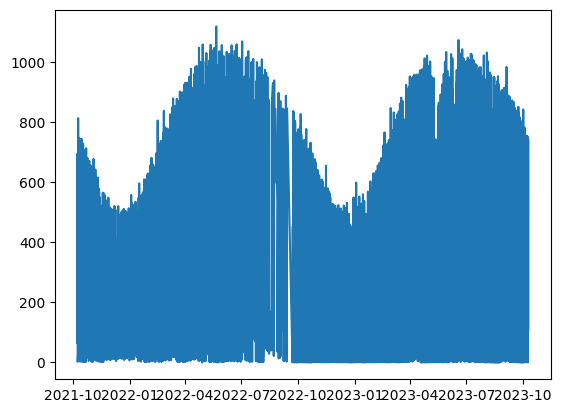

In [ ]:
plt.plot(data_df['Avg Global CMP22 (vent/cor) [W/m^2]'])
plt.show()

In [ ]:
data_df = data_df.rename(columns={"Avg Global CMP22 (vent/cor) [W/m^2]": "y"})
data_df.head(1)

,Avg Zenith Angle [degrees],Avg Sun Flag,Avg Opaque Cloud Cover [%],Avg Blue/Red_min,y,Avg BRBG Total Cloud Cover [%],Avg Azimuth Angle [degrees],Avg Albedo (CMP11),Avg Tower Dew Point Temp [deg C],Avg Total Cloud Cover [%],hour_of_day,day_of_year,month,Avg Global CMP22 (vent/cor) [W/m^2]_lagged_1
Timestamp,,,,,,,,,,,,,,
2021-10-08 07:00:00,85.6866,8.0,10.4667,0.9617,63.8407,13.6667,101.5014,0.2815,-1.122,19.9667,7,281,10,0.0


#**LSTM**

## 1. Base Model

In [ ]:
# Data Preprocessing
X = data_df[['Avg Zenith Angle [degrees]', 'Avg Sun Flag', 'Avg Opaque Cloud Cover [%]', 'Avg Blue/Red_min',
        'Avg BRBG Total Cloud Cover [%]', 'Avg Azimuth Angle [degrees]', 'Avg Albedo (CMP11)',
        'Avg Tower Dew Point Temp [deg C]', 'Avg Total Cloud Cover [%]',
        'hour_of_day', 'day_of_year', 'month','Avg Global CMP22 (vent/cor) [W/m^2]_lagged_1']]

y = data_df['y']


# Normalize the input features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the target variable using MinMaxScaler
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))  # Reshape y to be a 2D array

# Split the data into training and testing sets
# Ensure the data is not shuffled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Prepare sequences for the LSTM model
sequence_length = 12  # Adjust as needed
X_train_sequences = []
y_train_sequences = []

for i in range(sequence_length, len(X_train)):
    X_train_sequences.append(X_train[i - sequence_length:i])
    y_train_sequences.append(y_train[i])

X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)


# Build an LSTM model
model = keras.Sequential()
model.add(keras.layers.LSTM(100, activation='relu', input_shape=(sequence_length, X_train.shape[1])))
model.add(keras.layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and collect training history
history = model.fit(X_train_sequences, y_train_sequences, epochs=20, batch_size=12, validation_split=0.2)

# Prepare sequences for the test set
X_test_sequences = []

for i in range(sequence_length, len(X_test)):
    X_test_sequences.append(X_test[i - sequence_length:i])

X_test_sequences = np.array(X_test_sequences)

# Make predictions
y_pred = model.predict(X_test_sequences)

# Inverse transform the predictions to the original scale
y_pred = y_scaler.inverse_transform(y_pred)

# Inverse transform the training and testing target variables to the original scale
y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)



# Extract training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Optionally, you can inverse transform the predictions if you previously scaled the data

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test[sequence_length:], y_pred)
mae = mean_absolute_error(y_test[sequence_length:], y_pred)
r2 = r2_score(y_test[sequence_length:], y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')

# Create a plot of the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



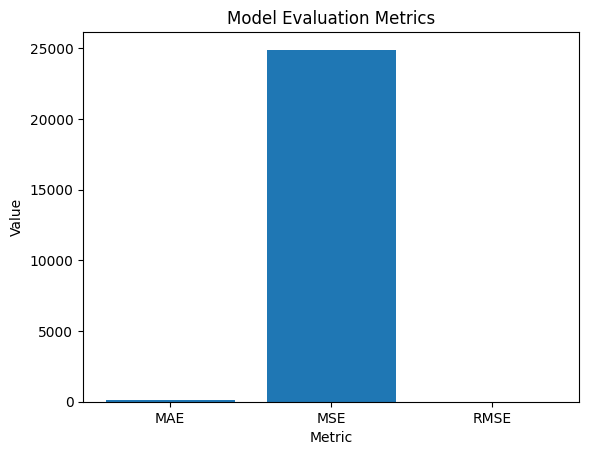

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot of evaluation metrics
metrics = ['MAE', 'MSE', 'RMSE']
values = [mae, mse, r2]

plt.bar(metrics, values)
plt.title('Model Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

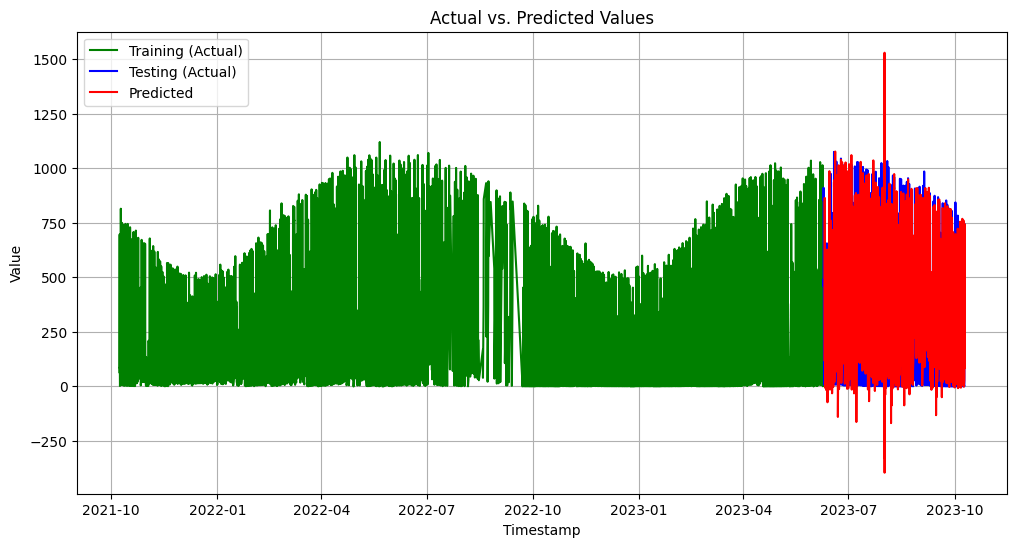

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have loaded your actual and predicted values earlier
# y_train contains training values, y_test contains testing values, and y_pred contains predicted values

# Plot the training values
plt.figure(figsize=(12, 6))
plt.plot(data_df.index[:len(y_train)], y_train, label='Training (Actual)', color='green')

# Plot the testing values
plt.plot(data_df.index[len(y_train):len(y_train) + len(y_test)], y_test, label='Testing (Actual)', color='blue')

# Plot the predicted values
plt.plot(data_df.index[len(y_train) + sequence_length:], y_pred, label='Predicted', color='red')

# Customize the plot
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## 2.Best model parameters from hyperparameter tuning

Best val_mean_squared_error So Far: 0.010461629368364811 Total elapsed time: 00h 56m 28s 55/55 [==============================] - 1s 8ms/step Mean Squared Error on Original Scale: 13159.588140057649 Best Hyperparameters: {'units': 120, 'dropout': 0.2, 'learning_rate': 0.001} Mean Absolute Error: 73.9487650941431 R-squared: 0.8737667667633169 RMSE: 114.71524807129019 Mean Squared Error on Original Scale: 13159.588140057649

Epoch 1/20
468/468 [==============================] - 14s 26ms/step - loss: 0.0214 - val_loss: 0.0138
Epoch 2/20
468/468 [==============================] - 5s 11ms/step - loss: 0.0120 - val_loss: 0.0125
Epoch 3/20
468/468 [==============================] - 7s 14ms/step - loss: 0.0103 - val_loss: 0.0111
Epoch 4/20
468/468 [==============================] - 6s 13ms/step - loss: 0.0099 - val_loss: 0.0110
Epoch 5/20
468/468 [==============================] - 5s 12ms/step - loss: 0.0094 - val_loss: 0.0107
Epoch 6/20
468/468 [==============================] - 7s 15ms/step - loss: 0.0088 - val_loss: 0.0103
Epoch 7/20
468/468 [==============================] - 5s 12ms/step - loss: 0.0087 - val_loss: 0.0103
Epoch 8/20
468/468 [==============================] - 7s 15ms/step - loss: 0.0085 - val_loss: 0.0106
Epoch 9/20
468/468 [==============================] - 6s 13ms/step - loss: 0.0084 - val_loss: 0.0110
Epoch 10/20
468/468 [==============================] - 7s 14ms/step - loss: 0.0079 - val_l

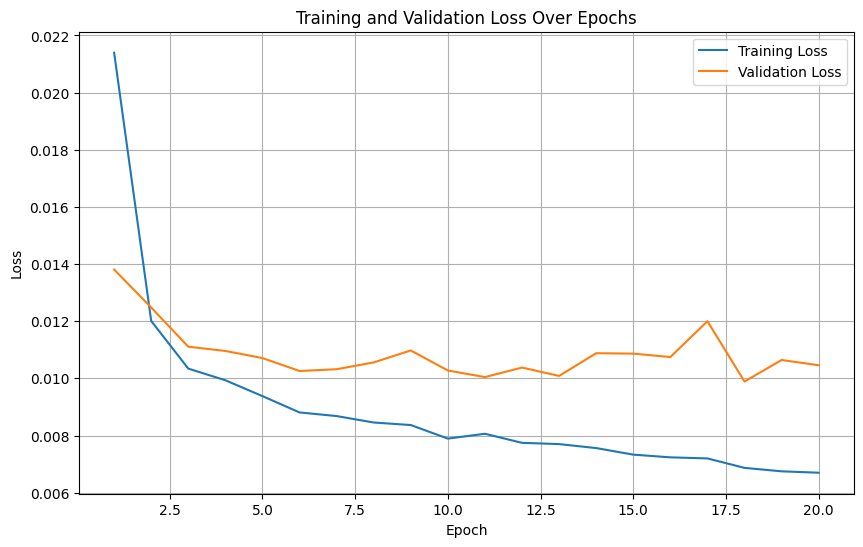

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data Preprocessing
X = data_df[['Avg Zenith Angle [degrees]', 'Avg Sun Flag', 'Avg Opaque Cloud Cover [%]', 'Avg Blue/Red_min',
        'Avg BRBG Total Cloud Cover [%]', 'Avg Azimuth Angle [degrees]', 'Avg Albedo (CMP11)',
        'Avg Tower Dew Point Temp [deg C]', 'Avg Total Cloud Cover [%]',
        'hour_of_day', 'day_of_year', 'month','Avg Global CMP22 (vent/cor) [W/m^2]_lagged_1']]

y = data_df['y']

# Normalize the input features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the target variable using MinMaxScaler
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))  # Reshape y to be a 2D array

# Split the data into training and testing sets
# Ensure the data is not shuffled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Prepare sequences for the LSTM model
sequence_length = 12  # Adjust as needed
X_train_sequences = []
y_train_sequences = []

for i in range(sequence_length, len(X_train)):
    X_train_sequences.append(X_train[i - sequence_length:i])
    y_train_sequences.append(y_train[i])

X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)

# Build an LSTM model with the best hyperparameters
model = keras.Sequential()
model.add(keras.layers.LSTM(120, activation='relu', input_shape=(sequence_length, X_train.shape[1])))
model.add(keras.layers.Dropout(0.2))  # Add dropout as per the best hyperparameters
model.add(keras.layers.Dense(1))

# Compile the model with the specified learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model and collect training history
history = model.fit(X_train_sequences, y_train_sequences, epochs=20, batch_size=12, validation_split=0.2)

# Prepare sequences for the test set
X_test_sequences = []

for i in range(sequence_length, len(X_test)):
    X_test_sequences.append(X_test[i - sequence_length:i])

X_test_sequences = np.array(X_test_sequences)

# Make predictions
y_pred = model.predict(X_test_sequences)

# Inverse transform the predictions to the original scale
y_pred = y_scaler.inverse_transform(y_pred)

# Inverse transform the training and testing target variables to the original scale
y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

# Calculate metrics on the original scale
mse_original_scale = mean_squared_error(y_test[sequence_length:], y_pred)
mae_original_scale = mean_absolute_error(y_test[sequence_length:], y_pred)
r2_original_scale = r2_score(y_test[sequence_length:], y_pred)
rmse_original_scale = np.sqrt(mse_original_scale)

print(f'Mean Squared Error on Original Scale: {mse_original_scale}')
print(f'Mean Absolute Error on Original Scale: {mae_original_scale}')
print(f'R-squared on Original Scale: {r2_original_scale}')
print(f'RMSE on Original Scale: {rmse_original_scale}')

# Create a plot of the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


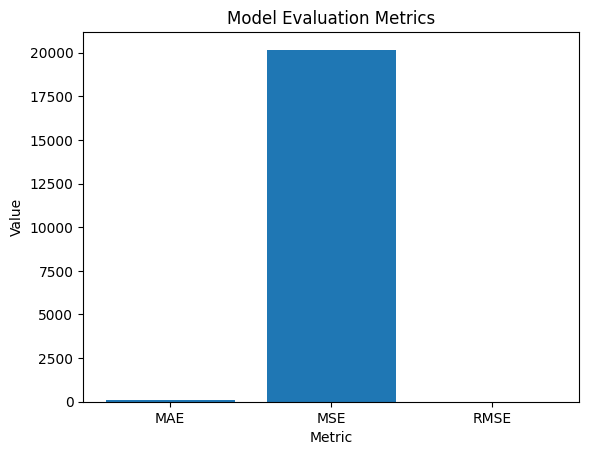

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot of evaluation metrics
metrics = ['MAE', 'MSE', 'RMSE']
values = [mae, mse, r2]

plt.bar(metrics, values)
plt.title('Model Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

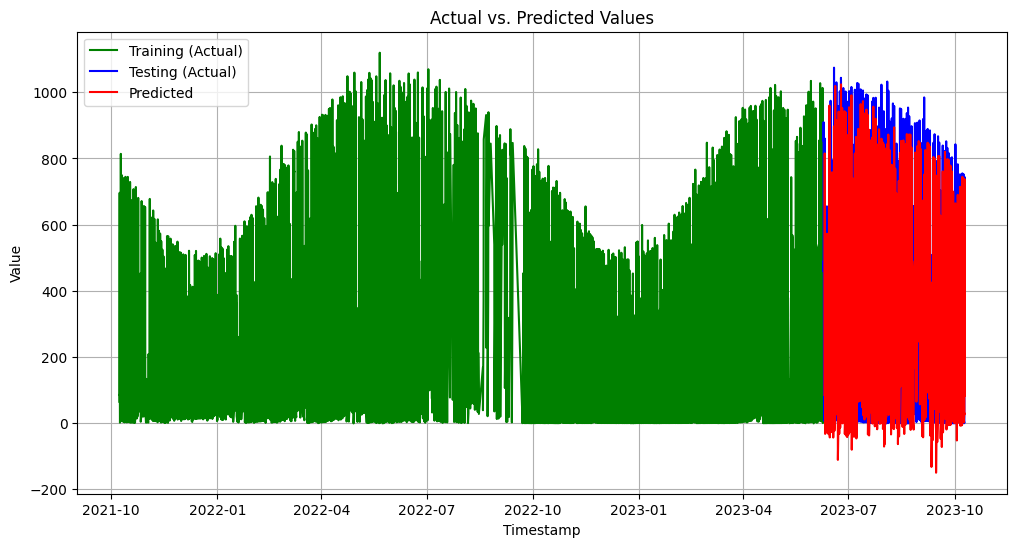

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have loaded your actual and predicted values earlier
# y_train contains training values, y_test contains testing values, and y_pred contains predicted values

# Plot the training values
plt.figure(figsize=(12, 6))
plt.plot(data_df.index[:len(y_train)], y_train, label='Training (Actual)', color='green')

# Plot the testing values
plt.plot(data_df.index[len(y_train):len(y_train) + len(y_test)], y_test, label='Testing (Actual)', color='blue')

# Plot the predicted values
plt.plot(data_df.index[len(y_train) + sequence_length:], y_pred, label='Predicted', color='red')

# Customize the plot
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## 3. Rolling window training

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data Preprocessing
X = data_df[['Avg Zenith Angle [degrees]', 'Avg Sun Flag', 'Avg Opaque Cloud Cover [%]', 'Avg Blue/Red_min',
        'Avg BRBG Total Cloud Cover [%]', 'Avg Azimuth Angle [degrees]', 'Avg Albedo (CMP11)',
        'Avg Tower Dew Point Temp [deg C]', 'Avg Total Cloud Cover [%]',
        'hour_of_day', 'day_of_year', 'month']]

y = data_df['y']

# Normalize the input features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the target variable using MinMaxScaler
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Define minimum training size and window size
min_training_size = 2000
window_size = 12  # You can adjust the window size

# Initialize variables for rolling window training
start_idx = 0
end_idx = min_training_size
validation_size = 10  # Adjust the size of the validation set

# Create lists to store training and validation performance metrics
training_losses = []
validation_losses = []
iteration = 1
while end_idx < len(X):
    # Extract the current training and validation data
    X_train = X[start_idx:end_idx]
    y_train = y[start_idx:end_idx]

    # Determine the size of the validation set for this iteration
    if end_idx + validation_size > len(X):
        validation_size = len(X) - end_idx

    X_val = X[end_idx:end_idx + validation_size]
    y_val = y[end_idx:end_idx + validation_size]

    # Create sequences for the LSTM model
    X_train_sequences, y_train_sequences = [], []

    for i in range(window_size, len(X_train)):
        X_train_sequences.append(X_train[i - window_size:i])
        y_train_sequences.append(y_train[i])

    X_train_sequences = np.array(X_train_sequences)
    y_train_sequences = np.array(y_train_sequences)

    # Build an LSTM model
    def create_lstm_model(n_lstm_units=120, learning_rate=0.001):
        model = keras.Sequential()
        model.add(keras.layers.LSTM(n_lstm_units, activation='relu', input_shape=(window_size, X_train.shape[1])))
        model.add(keras.layers.Dense(1))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
        return model

    model = create_lstm_model()

    # Train the model
    history = model.fit(X_train_sequences, y_train_sequences, epochs=20, batch_size=12, validation_split=0.2)

    # Evaluate and store training and validation losses
    training_loss = history.history['loss'][-1]
    validation_loss = history.history['val_loss'][-1]
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)

    # Save the model after each iteration
    model.save(f"/content/drive/MyDrive/Forecasting Models/LSTM/Rolling Window Iterations/{iteration}.h5")

    # Make predictions on the validation data
    X_val_sequences, y_val_sequences = [], []

    for i in range(window_size, len(X_val)):
        X_val_sequences.append(X_val[i - window_size:i])
        y_val_sequences.append(y_val[i])

    X_val_sequences = np.array(X_val_sequences)
    y_val_sequences = np.array(y_val_sequences)

    y_pred = model.predict(X_val_sequences)

    # Inverse transform the predictions to the original scale
    y_pred = y_scaler.inverse_transform(y_pred)

    # Inverse transform the validation data to the original scale
    y_val = y_scaler.inverse_transform(y_val_sequences)

    # Evaluate the model
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    rmse = np.sqrt(mse)

    print(f'Iteration {len(validation_losses)}: Training Loss = {training_loss}, Validation Loss = {validation_loss}')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')
    print(f'RMSE: {rmse}')

    # Update indices for the next iteration
    start_idx += validation_size
    end_idx += validation_size
    iteration += 1

# Print or analyze training and validation losses as needed
for i, (train_loss, val_loss) in enumerate(zip(training_losses, validation_losses)):
    print(f'Iteration {i + 1}: Training Loss = {train_loss}, Validation Loss = {val_loss}')



Epoch 1/20
133/133 [==============================] - 4s 14ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 2/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0040 - val_loss: 0.0150
Epoch 3/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0036 - val_loss: 0.0112
Epoch 4/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0031 - val_loss: 0.0105
Epoch 5/20
133/133 [==============================] - 2s 11ms/step - loss: 0.0030 - val_loss: 0.0116
Epoch 6/20
133/133 [==============================] - 2s 18ms/step - loss: 0.0028 - val_loss: 0.0125
Epoch 7/20
133/133 [==============================] - 3s 25ms/step - loss: 0.0028 - val_loss: 0.0117
Epoch 8/20
133/133 [==============================] - 2s 14ms/step - loss: 0.0028 - val_loss: 0.0110
Epoch 9/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0025 - val_loss: 0.0101
Epoch 10/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0027 - val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 11ms/step
Iteration 1: Training Loss = 0.0020882466342300177, Validation Loss = 0.009899708442389965
Mean Squared Error: 25923.78984637615
Mean Absolute Error: 115.21465011820627
R-squared: 0.7663952098950596
RMSE: 161.00866388606593
Epoch 1/20
133/133 [==============================] - 5s 15ms/step - loss: 0.0219 - val_loss: 0.0132
Epoch 2/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0054 - val_loss: 0.0112
Epoch 3/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0047 - val_loss: 0.0136
Epoch 4/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0044 - val_loss: 0.0118
Epoch 5/20
133/133 [==============================] - 2s 17ms/step - loss: 0.0040 - val_loss: 0.0101
Epoch 6/20
133/133 [==============================] - 3s 21ms/step - loss: 0.0041 - val_loss: 0.0098
Epoch 7/20
133/133 [==============================] - 2s 14ms/step - loss: 0.0037 - val_loss: 0.0108
Epoch 8/20
133/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 7ms/step
Iteration 2: Training Loss = 0.0027291136793792248, Validation Loss = 0.010827308520674706
Mean Squared Error: 43601.59844796506
Mean Absolute Error: 146.31532430248103
R-squared: 0.6091111338053952
RMSE: 208.80995773182144
Epoch 1/20
133/133 [==============================] - 3s 14ms/step - loss: 0.0181 - val_loss: 0.0204
Epoch 2/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0080 - val_loss: 0.0222
Epoch 3/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0069 - val_loss: 0.0232
Epoch 4/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0062 - val_loss: 0.0183
Epoch 5/20
133/133 [==============================] - 3s 19ms/step - loss: 0.0060 - val_loss: 0.0181
Epoch 6/20
133/133 [==============================] - 3s 24ms/step - loss: 0.0056 - val_loss: 0.0203
Epoch 7/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0056 - val_loss: 0.0293
Epoch 8/20
133/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 12ms/step
Iteration 3: Training Loss = 0.0039605251513421535, Validation Loss = 0.019900048151612282
Mean Squared Error: 113804.48118800037
Mean Absolute Error: 273.17174807912284
R-squared: -0.10871847349314745
RMSE: 337.3491976987649
Epoch 1/20
133/133 [==============================] - 4s 16ms/step - loss: 0.0217 - val_loss: 0.0503
Epoch 2/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0127 - val_loss: 0.0447
Epoch 3/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0115 - val_loss: 0.0420
Epoch 4/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0101 - val_loss: 0.0394
Epoch 5/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0095 - val_loss: 0.0437
Epoch 6/20
133/133 [==============================] - 3s 19ms/step - loss: 0.0092 - val_loss: 0.0442
Epoch 7/20
133/133 [==============================] - 3s 21ms/step - loss: 0.0087 - val_loss: 0.0426
Epoch 8/20
13

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 6ms/step
Iteration 4: Training Loss = 0.006362235639244318, Validation Loss = 0.04158438742160797
Mean Squared Error: 56826.99558237241
Mean Absolute Error: 179.7313806510644
R-squared: 0.33206009526893787
RMSE: 238.38413450221978
Epoch 1/20
133/133 [==============================] - 5s 22ms/step - loss: 0.0353 - val_loss: 0.0426
Epoch 2/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0222 - val_loss: 0.0265
Epoch 3/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0201 - val_loss: 0.0406
Epoch 4/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0183 - val_loss: 0.0537
Epoch 5/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0178 - val_loss: 0.0541
Epoch 6/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0173 - val_loss: 0.1008
Epoch 7/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0167 - val_loss: 0.0926
Epoch 8/20
133/133

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 5ms/step
Iteration 5: Training Loss = 0.01166043896228075, Validation Loss = 0.20438691973686218
Mean Squared Error: 1206332.9611946421
Mean Absolute Error: 1012.5153612731933
R-squared: -23.603325448273107
RMSE: 1098.3318993795283
Epoch 1/20
133/133 [==============================] - 3s 14ms/step - loss: 0.0320 - val_loss: 0.0059
Epoch 2/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0219 - val_loss: 0.0059
Epoch 3/20
133/133 [==============================] - 3s 20ms/step - loss: 0.0195 - val_loss: 0.0046
Epoch 4/20
133/133 [==============================] - 2s 17ms/step - loss: 0.0184 - val_loss: 0.0051
Epoch 5/20
133/133 [==============================] - 2s 11ms/step - loss: 0.0175 - val_loss: 0.0032
Epoch 6/20
133/133 [==============================] - 2s 11ms/step - loss: 0.0168 - val_loss: 0.0033
Epoch 7/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0163 - val_loss: 0.0037
Epoch 8/20
133/13

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 6ms/step
Iteration 6: Training Loss = 0.011489415541291237, Validation Loss = 0.004446526523679495
Mean Squared Error: 13767.064651976765
Mean Absolute Error: 87.5010909888037
R-squared: 0.5497468525164826
RMSE: 117.33313535390063
Epoch 1/20
133/133 [==============================] - 3s 14ms/step - loss: 0.0277 - val_loss: 0.0138
Epoch 2/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0179 - val_loss: 0.0108
Epoch 3/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0158 - val_loss: 0.0060
Epoch 4/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0145 - val_loss: 0.0071
Epoch 5/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0144 - val_loss: 0.0092
Epoch 6/20
133/133 [==============================] - 3s 19ms/step - loss: 0.0134 - val_loss: 0.0094
Epoch 7/20
133/133 [==============================] - 2s 17ms/step - loss: 0.0138 - val_loss: 0.0207
Epoch 8/20
133/133

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 6ms/step
Iteration 7: Training Loss = 0.009024024941027164, Validation Loss = 0.06474845111370087
Mean Squared Error: 669248.4987753761
Mean Absolute Error: 631.6739088008318
R-squared: -13.351254470728417
RMSE: 818.076095956468
Epoch 1/20
133/133 [==============================] - 3s 13ms/step - loss: 0.0157 - val_loss: 0.0106
Epoch 2/20
133/133 [==============================] - 2s 11ms/step - loss: 0.0089 - val_loss: 0.0067
Epoch 3/20
133/133 [==============================] - 2s 11ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 4/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0066 - val_loss: 0.0056
Epoch 5/20
133/133 [==============================] - 2s 16ms/step - loss: 0.0062 - val_loss: 0.0038
Epoch 6/20
133/133 [==============================] - 3s 19ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 7/20
133/133 [==============================] - 2s 14ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 8/20
133/133 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 6ms/step
Iteration 8: Training Loss = 0.003222191473469138, Validation Loss = 0.008640901185572147
Mean Squared Error: 15833.256165319573
Mean Absolute Error: 97.54230091966313
R-squared: 0.8102961274417586
RMSE: 125.83026728621208
Epoch 1/20
133/133 [==============================] - 3s 14ms/step - loss: 0.0107 - val_loss: 0.0100
Epoch 2/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0040 - val_loss: 0.0123
Epoch 3/20
133/133 [==============================] - 2s 11ms/step - loss: 0.0039 - val_loss: 0.0123
Epoch 4/20
133/133 [==============================] - 2s 14ms/step - loss: 0.0028 - val_loss: 0.0108
Epoch 5/20
133/133 [==============================] - 3s 19ms/step - loss: 0.0027 - val_loss: 0.0092
Epoch 6/20
133/133 [==============================] - 2s 16ms/step - loss: 0.0026 - val_loss: 0.0096
Epoch 7/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0024 - val_loss: 0.0078
Epoch 8/20
133/13

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 10ms/step
Iteration 9: Training Loss = 0.0017632594099268317, Validation Loss = 0.007967283949255943
Mean Squared Error: 26681.68552698997
Mean Absolute Error: 109.18158104684127
R-squared: 0.7600363764925676
RMSE: 163.3452953928884
Epoch 1/20
133/133 [==============================] - 4s 18ms/step - loss: 0.0165 - val_loss: 0.0163
Epoch 2/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0050 - val_loss: 0.0146
Epoch 3/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0044 - val_loss: 0.0140
Epoch 4/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0040 - val_loss: 0.0122
Epoch 5/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0039 - val_loss: 0.0148
Epoch 6/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0035 - val_loss: 0.0118
Epoch 7/20
133/133 [==============================] - 2s 15ms/step - loss: 0.0035 - val_loss: 0.0106
Epoch 8/20
133/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 11ms/step
Iteration 10: Training Loss = 0.00251990114338696, Validation Loss = 0.014916392043232918
Mean Squared Error: 65599.91487852784
Mean Absolute Error: 179.87213619966536
R-squared: 0.2762820678080262
RMSE: 256.1248033255035
Epoch 1/20
133/133 [==============================] - 4s 17ms/step - loss: 0.0181 - val_loss: 0.0202
Epoch 2/20
133/133 [==============================] - 2s 11ms/step - loss: 0.0082 - val_loss: 0.0195
Epoch 3/20
133/133 [==============================] - 2s 11ms/step - loss: 0.0074 - val_loss: 0.0272
Epoch 4/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0067 - val_loss: 0.0195
Epoch 5/20
133/133 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 0.0191
Epoch 6/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0060 - val_loss: 0.0209
Epoch 7/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0057 - val_loss: 0.0172
Epoch 8/20
133/13

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 6ms/step
Iteration 11: Training Loss = 0.004253446124494076, Validation Loss = 0.01902170665562153
Mean Squared Error: 24082.358663486877
Mean Absolute Error: 112.71721157422347
R-squared: 0.7790183666782592
RMSE: 155.1849176417827
Epoch 1/20
133/133 [==============================] - 3s 13ms/step - loss: 0.0271 - val_loss: 0.0192
Epoch 2/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0132 - val_loss: 0.0188
Epoch 3/20
133/133 [==============================] - 3s 19ms/step - loss: 0.0119 - val_loss: 0.0125
Epoch 4/20
133/133 [==============================] - 2s 17ms/step - loss: 0.0106 - val_loss: 0.0156
Epoch 5/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0106 - val_loss: 0.0173
Epoch 6/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0097 - val_loss: 0.0132
Epoch 7/20
133/133 [==============================] - 2s 11ms/step - loss: 0.0097 - val_loss: 0.0142
Epoch 8/20
133/13

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 6ms/step
Iteration 12: Training Loss = 0.007149524055421352, Validation Loss = 0.017515288665890694
Mean Squared Error: 25747.30965685321
Mean Absolute Error: 120.20504471454366
R-squared: 0.7648112354791573
RMSE: 160.45968234062167
Epoch 1/20
133/133 [==============================] - 3s 14ms/step - loss: 0.0200 - val_loss: 0.0201
Epoch 2/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0142 - val_loss: 0.0190
Epoch 3/20
133/133 [==============================] - 2s 11ms/step - loss: 0.0127 - val_loss: 0.0173
Epoch 4/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0121 - val_loss: 0.0235
Epoch 5/20
133/133 [==============================] - 2s 14ms/step - loss: 0.0120 - val_loss: 0.0175
Epoch 6/20
133/133 [==============================] - 3s 19ms/step - loss: 0.0114 - val_loss: 0.0173
Epoch 7/20
133/133 [==============================] - 2s 17ms/step - loss: 0.0111 - val_loss: 0.0177
Epoch 8/20
133/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 5ms/step
Iteration 13: Training Loss = 0.008434559218585491, Validation Loss = 0.0183660127222538
Mean Squared Error: 25002.835315067114
Mean Absolute Error: 109.21927705658695
R-squared: 0.7612172583489873
RMSE: 158.12284880771378
Epoch 1/20
133/133 [==============================] - 3s 13ms/step - loss: 0.0233 - val_loss: 0.0256
Epoch 2/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0151 - val_loss: 0.0215
Epoch 3/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0148 - val_loss: 0.0197
Epoch 4/20
133/133 [==============================] - 2s 11ms/step - loss: 0.0139 - val_loss: 0.0197
Epoch 5/20
133/133 [==============================] - 2s 16ms/step - loss: 0.0129 - val_loss: 0.0172
Epoch 6/20
133/133 [==============================] - 3s 19ms/step - loss: 0.0126 - val_loss: 0.0176
Epoch 7/20
133/133 [==============================] - 2s 14ms/step - loss: 0.0121 - val_loss: 0.0161
Epoch 8/20
133/13

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 0s 6ms/step
Iteration 14: Training Loss = 0.009417789056897163, Validation Loss = 0.01640915311872959
Mean Squared Error: 14266.842439103508
Mean Absolute Error: 95.02897406407881
R-squared: 0.8277695509652199
RMSE: 119.44388824508145
Iteration 1: Training Loss = 0.0020882466342300177, Validation Loss = 0.009899708442389965
Iteration 2: Training Loss = 0.0027291136793792248, Validation Loss = 0.010827308520674706
Iteration 3: Training Loss = 0.0039605251513421535, Validation Loss = 0.019900048151612282
Iteration 4: Training Loss = 0.006362235639244318, Validation Loss = 0.04158438742160797
Iteration 5: Training Loss = 0.01166043896228075, Validation Loss = 0.20438691973686218
Iteration 6: Training Loss = 0.011489415541291237, Validation Loss = 0.004446526523679495
Iteration 7: Training Loss = 0.009024024941027164, Validation Loss = 0.06474845111370087
Iteration 8: Training Loss = 0.003222191473469138, Validation Loss = 0.008640901185572147
Iterati

### Evaluating all the models from each iteration

In [ ]:
import os
import glob

# Data Preprocessing
X = data_df[['Avg Zenith Angle [degrees]', 'Avg Sun Flag', 'Avg Opaque Cloud Cover [%]', 'Avg Blue/Red_min',
        'Avg BRBG Total Cloud Cover [%]', 'Avg Azimuth Angle [degrees]', 'Avg Albedo (CMP11)',
        'Avg Tower Dew Point Temp [deg C]', 'Avg Total Cloud Cover [%]',
        'hour_of_day', 'day_of_year', 'month']]

y = data_df['y']

# Normalize the input features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the target variable using MinMaxScaler
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
# Ensure the data is not shuffled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the directory where your models are stored
model_directory = '/content/drive/MyDrive/Forecasting Models/LSTM/Rolling Window Iterations'

# Create empty lists to store model performance metrics
model_names = []
mse_values = []
mae_values = []
r2_values = []
rmse_values = []

# List all model files in the directory
model_files = os.listdir(model_directory)

# Sort the model files to ensure they are processed in the correct order
model_files.sort(key=lambda x: int(x.split('.')[0]))

# Loop through each model file and evaluate
for model_file in model_files:
    if model_file.endswith('.h5'):
        model_path = os.path.join(model_directory, model_file)

        # Load the model
        model = keras.models.load_model(model_path)

        # Prepare sequences for the test set
        X_test_sequences = []
        y_test_sequences = []

        for i in range(sequence_length, len(X_test)):
            X_test_sequences.append(X_test[i - sequence_length:i])
            y_test_sequences.append(y_test[i])

        X_test_sequences = np.array(X_test_sequences)
        y_test_sequences = np.array(y_test_sequences)

        # Make predictions
        y_pred = model.predict(X_test_sequences)

        # Inverse transform the predictions to the original scale
        y_pred = y_scaler.inverse_transform(y_pred)

        # Inverse transform the target variable to the original scale
        y_test_original = y_scaler.inverse_transform(y_test_sequences)

        # Calculate metrics
        mse = mean_squared_error(y_test_original, y_pred)
        mae = mean_absolute_error(y_test_original, y_pred)
        r2 = r2_score(y_test_original, y_pred)
        rmse = np.sqrt(mse)

        # Store model name and metrics
        model_names.append(model_file)
        mse_values.append(mse)
        mae_values.append(mae)
        r2_values.append(r2)
        rmse_values.append(rmse)

# Print or store the model names and corresponding metrics
for model_name, mse, mae, r2, rmse in zip(model_names, mse_values, mae_values, r2_values, rmse_values):
    print(f'Model Name: {model_name}')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')
    print(f'RMSE: {rmse}')


55/55 [==============================] - 1s 6ms/step
Model Name: 1.h5
Mean Squared Error: 54932.32169834225
Mean Absolute Error: 177.14881612513827
R-squared: 0.4722134859330981
RMSE: 234.37645295195986
Model Name: 2.h5
Mean Squared Error: 39612.86524313238
Mean Absolute Error: 137.03552062580405
R-squared: 0.6194019219925724
RMSE: 199.0298099359299
Model Name: 3.h5
Mean Squared Error: 87605.78195369034
Mean Absolute Error: 241.97367282945598
R-squared: 0.15828880265880585
RMSE: 295.982739283375
Model Name: 4.h5
Mean Squared Error: 25657.388789937446
Mean Absolute Error: 113.62183474213543
R-squared: 0.7534853184639937
RMSE: 160.17923957222874
Model Name: 5.h5
Mean Squared Error: 71716.74679692124
Mean Absolute Error: 192.6944217380699
R-squared: 0.31094971736270194
RMSE: 267.79982598373965
Model Name: 6.h5
Mean Squared Error: 17715.937856297784
Mean Absolute Error: 96.24762493749469
R-squared: 0.8297863116737074
RMSE: 133.10123161074725
Model Name: 7.h5
Mean Squared Error: 22731.73788

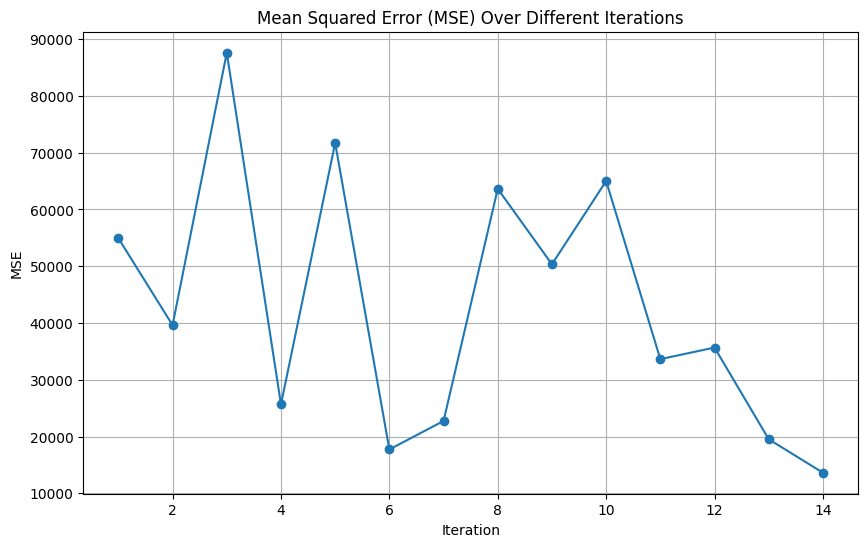

In [ ]:
# Create a list of iterations (assuming models are sorted by iteration)
iterations = list(range(1, len(model_names) + 1))

# Plot MSE values over iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, mse_values, marker='o', linestyle='-')
plt.title('Mean Squared Error (MSE) Over Different Iterations')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

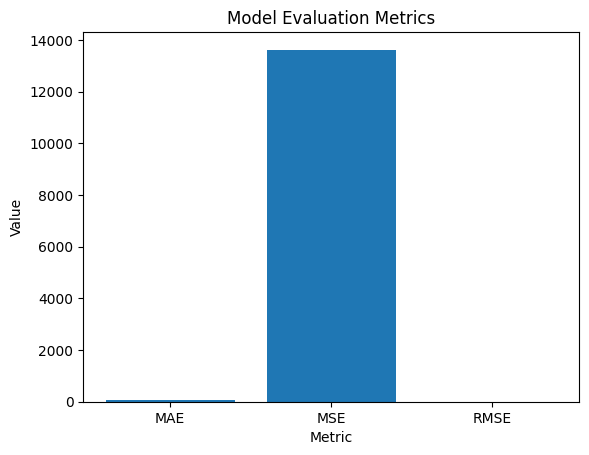

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot of evaluation metrics
# print(f'Model Name: {model_name}')
metrics = ['MAE', 'MSE', 'RMSE']
values = [mae, mse, r2]

plt.bar(metrics, values)
plt.title('Model Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

## Different Activation functions

### Sigmoid

Epoch 1/20
468/468 [==============================] - 10s 19ms/step - loss: 0.0435 - val_loss: 0.0178
Epoch 2/20
468/468 [==============================] - 6s 12ms/step - loss: 0.0211 - val_loss: 0.0187
Epoch 3/20
468/468 [==============================] - 8s 17ms/step - loss: 0.0163 - val_loss: 0.0156
Epoch 4/20
468/468 [==============================] - 6s 12ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 5/20
468/468 [==============================] - 8s 16ms/step - loss: 0.0132 - val_loss: 0.0151
Epoch 6/20
468/468 [==============================] - 6s 12ms/step - loss: 0.0122 - val_loss: 0.0139
Epoch 7/20
468/468 [==============================] - 7s 16ms/step - loss: 0.0119 - val_loss: 0.0133
Epoch 8/20
468/468 [==============================] - 6s 13ms/step - loss: 0.0117 - val_loss: 0.0143
Epoch 9/20
468/468 [==============================] - 7s 15ms/step - loss: 0.0111 - val_loss: 0.0124
Epoch 10/20
468/468 [==============================] - 7s 14ms/step - loss: 0.0108 - val_l

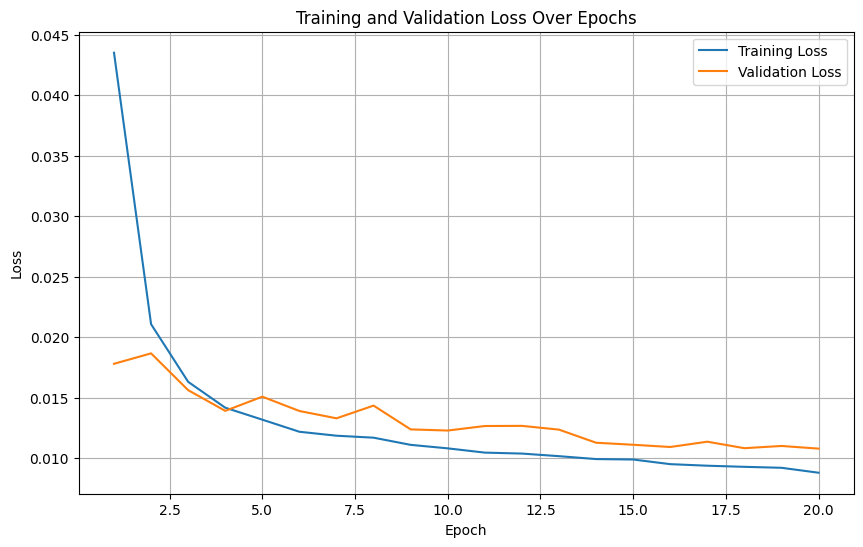

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data Preprocessing
X = data_df[['Avg Zenith Angle [degrees]', 'Avg Sun Flag', 'Avg Opaque Cloud Cover [%]', 'Avg Blue/Red_min',
        'Avg BRBG Total Cloud Cover [%]', 'Avg Azimuth Angle [degrees]', 'Avg Albedo (CMP11)',
        'Avg Tower Dew Point Temp [deg C]', 'Avg Total Cloud Cover [%]',
        'hour_of_day', 'day_of_year', 'month']]

y = data_df['y']

# Normalize the input features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the target variable using MinMaxScaler
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))  # Reshape y to be a 2D array

# Split the data into training and testing sets
# Ensure the data is not shuffled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Prepare sequences for the LSTM model
sequence_length = 12  # Adjust as needed
X_train_sequences = []
y_train_sequences = []

for i in range(sequence_length, len(X_train)):
    X_train_sequences.append(X_train[i - sequence_length:i])
    y_train_sequences.append(y_train[i])

X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)

# Build an LSTM model with the best hyperparameters
model = keras.Sequential()
model.add(keras.layers.LSTM(120, activation='sigmoid', input_shape=(sequence_length, X_train.shape[1])))
model.add(keras.layers.Dropout(0.2))  # Add dropout as per the best hyperparameters
model.add(keras.layers.Dense(1))

# Compile the model with the specified learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Define early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore the best model weights based on validation loss
)

# Train the model and collect training history
history = model.fit(X_train_sequences, y_train_sequences,
                    epochs=20, batch_size=12,
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Prepare sequences for the test set
X_test_sequences = []

for i in range(sequence_length, len(X_test)):
    X_test_sequences.append(X_test[i - sequence_length:i])

X_test_sequences = np.array(X_test_sequences)

# Make predictions
y_pred = model.predict(X_test_sequences)

# Inverse transform the predictions to the original scale
y_pred = y_scaler.inverse_transform(y_pred)

# Inverse transform the training and testing target variables to the original scale
y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

# Calculate metrics on the original scale
mse_original_scale = mean_squared_error(y_test[sequence_length:], y_pred)
mae_original_scale = mean_absolute_error(y_test[sequence_length:], y_pred)
r2_original_scale = r2_score(y_test[sequence_length:], y_pred)
rmse_original_scale = np.sqrt(mse_original_scale)

print(f'Mean Squared Error on Original Scale: {mse_original_scale}')
print(f'Mean Absolute Error on Original Scale: {mae_original_scale}')
print(f'R-squared on Original Scale: {r2_original_scale}')
print(f'RMSE on Original Scale: {rmse_original_scale}')

# Create a plot of the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Tanh

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.regularizers import l2

# Data Preprocessing (Assuming you have already loaded and preprocessed your data)
X = data_df[['Avg Zenith Angle [degrees]', 'Avg Sun Flag', 'Avg Opaque Cloud Cover [%]', 'Avg Blue/Red_min',
        'Avg BRBG Total Cloud Cover [%]', 'Avg Azimuth Angle [degrees]', 'Avg Albedo (CMP11)',
        'Avg Tower Dew Point Temp [deg C]', 'Avg Total Cloud Cover [%]',
        'hour_of_day', 'day_of_year', 'month']]

y = data_df['y']

# Normalize the input features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the target variable using MinMaxScaler
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))  # Reshape y to be a 2D array

# Split the data into training and testing sets
# Ensure the data is not shuffled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Prepare sequences for the LSTM model
sequence_length = 12  # Adjust as needed
X_train_sequences = []
y_train_sequences = []

for i in range(sequence_length, len(X_train)):
    X_train_sequences.append(X_train[i - sequence_length:i])
    y_train_sequences.append(y_train[i])

X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)

# Build an LSTM model with more layers and different activations
model = keras.Sequential()
model.add(keras.layers.LSTM(120, activation='tanh', return_sequences=True,
                            input_shape=(sequence_length, X_train.shape[1]),
                           kernel_regularizer=l2(0.001),
                          bias_regularizer=l2(0.001)))
# model.add(keras.layers.LSTM(120, activation='tanh', return_sequences=True))  # Add another LSTM layer
model.add(keras.layers.Dropout(0.2))  # Add dropout as per the best hyperparameters
model.add(keras.layers.Dense(1))

# Compile the model with the specified learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Define early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore the best model weights based on validation loss
)

# Train the model and collect training history
history = model.fit(X_train_sequences, y_train_sequences, epochs=20, batch_size=12, validation_split=0.2, callbacks=[early_stopping])

# Prepare sequences for the test set
X_test_sequences = []

for i in range(sequence_length, len(X_test)):
    X_test_sequences.append(X_test[i - sequence_length:i])

X_test_sequences = np.array(X_test_sequences)

# Make predictions
y_pred = model.predict(X_test_sequences)

# Reshape y_pred from 3D to 2D if model has more layers
# y_pred = y_pred.reshape(-1, 1)

# Inverse transform the predictions to the original scale
y_pred = y_scaler.inverse_transform(y_pred)

# Inverse transform the training and testing target variables to the original scale
y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

# Calculate metrics on the original scale
mse_original_scale = mean_squared_error(y_test[sequence_length:], y_pred)
mae_original_scale = mean_absolute_error(y_test[sequence_length:], y_pred)
r2_original_scale = r2_score(y_test[sequence_length:], y_pred)
rmse_original_scale = np.sqrt(mse_original_scale)

print(f'Mean Squared Error on Original Scale: {mse_original_scale}')
print(f'Mean Absolute Error on Original Scale: {mae_original_scale}')
print(f'R-squared on Original Scale: {r2_original_scale}')
print(f'RMSE on Original Scale: {rmse_original_scale}')

# Create a plot of the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Reshape y_pred from 3D to 2D if model has more layers
y_pred = y_pred.reshape(-1, 1)

# Inverse transform the predictions to the original scale
y_pred = y_scaler.inverse_transform(y_pred)

# Inverse transform the training and testing target variables to the original scale
y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

# Calculate metrics on the original scale
mse_original_scale = mean_squared_error(y_test[sequence_length:], y_pred)
mae_original_scale = mean_absolute_error(y_test[sequence_length:], y_pred)
r2_original_scale = r2_score(y_test[sequence_length:], y_pred)
rmse_original_scale = np.sqrt(mse_original_scale)

print(f'Mean Squared Error on Original Scale: {mse_original_scale}')
print(f'Mean Absolute Error on Original Scale: {mae_original_scale}')
print(f'R-squared on Original Scale: {r2_original_scale}')
print(f'RMSE on Original Scale: {rmse_original_scale}')

# Create a plot of the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 4. Hyperparameter Tuning

In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


# Data Preprocessing
X = data_df[['Avg Zenith Angle [degrees]', 'Avg Sun Flag', 'Avg Opaque Cloud Cover [%]', 'Avg Blue/Red_min',
        'Avg BRBG Total Cloud Cover [%]', 'Avg Azimuth Angle [degrees]', 'Avg Albedo (CMP11)',
        'Avg Tower Dew Point Temp [deg C]', 'Avg Total Cloud Cover [%]',
        'hour_of_day', 'day_of_year', 'month']]

y = data_df['y']

# Normalize the input features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the target variable using MinMaxScaler
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))  # Reshape y to be a 2D array

# Split the data into training and testing sets
# Ensure the data is not shuffled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the function to build and compile the LSTM model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('units', min_value=50, max_value=200, step=10), activation='relu',
                   input_shape=(sequence_length, X_train.shape[1]), kernel_initializer='uniform'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=['mean_squared_error'])
    return model

# Create a RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=15,  # Adjust this as needed
    directory='/content/drive/MyDrive/Forecasting Models/LSTM',  # Specify a directory for saving results
    project_name='lstm_hyperparameter_tuning')

# Perform hyperparameter tuning
tuner.search(X_train_sequences, y_train_sequences, validation_data=(X_test_sequences, y_test[sequence_length:]), epochs=50)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Make predictions using the best model
y_pred = best_model.predict(X_test_sequences)

# Inverse transform the predictions to the original scale
y_pred = y_scaler.inverse_transform(y_pred)

# Inverse transform the training and testing target variables to the original scale
y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

# Calculate the mean squared error on the original scale for testing data
mse = mean_squared_error(y_test[sequence_length:], y_pred)
print(f'Mean Squared Error on Original Scale: {mse}')

# Print best hyperparameters
best_hparams = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
print(best_hparams.values)

# Evaluate the best model
mse = mean_squared_error(y_test[sequence_length:], y_pred)
mae = mean_absolute_error(y_test[sequence_length:], y_pred)
r2 = r2_score(y_test[sequence_length:], y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')
print(f'Mean Squared Error on Original Scale: {mse}')


Trial 15 Complete [00h 02m 25s]
val_mean_squared_error: 0.0932956263422966

Best val_mean_squared_error So Far: 0.08780858665704727
Total elapsed time: 00h 26m 20s
55/55 [==============================] - 0s 3ms/step
Mean Squared Error on Original Scale: 110453.61311381502
Best Hyperparameters:
{'units': 90, 'dropout': 0.4, 'learning_rate': 0.0001}
Mean Absolute Error: 286.38702080306047
R-squared: -0.06123181451465798
RMSE: 332.3456229797754
Mean Squared Error on Original Scale: 110453.61311381502


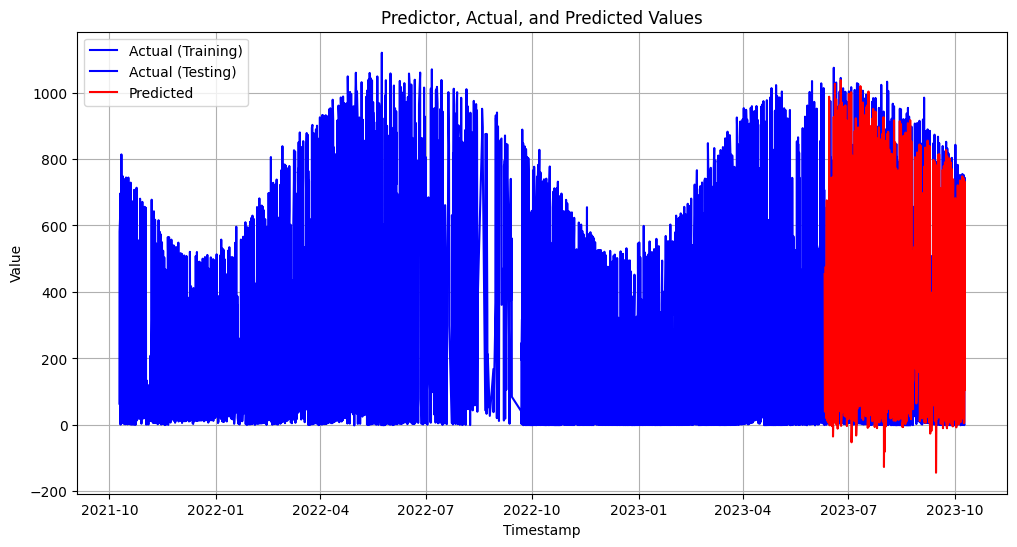

In [ ]:
# Using the best model predictions

# Plot the actual predictor values
plt.figure(figsize=(12, 6))
plt.plot(data_df.index[sequence_length:len(y_train) + sequence_length], y_train, label='Actual (Training)', color='blue')

# Plot the actual target values
plt.plot(data_df.index[len(y_train) + sequence_length:], y_test[sequence_length:], label='Actual (Testing)', color='blue')

# Plot the predicted target values
plt.plot(data_df.index[len(y_train) + sequence_length:], y_pred, label='Predicted', color='red')

# Customize the plot
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Predictor, Actual, and Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


Best val_mean_squared_error So Far: 0.010461629368364811
Total elapsed time: 00h 56m 28s
55/55 [==============================] - 1s 8ms/step
Mean Squared Error on Original Scale: 13159.588140057649
Best Hyperparameters:
{'units': 120, 'dropout': 0.2, 'learning_rate': 0.001}
Mean Absolute Error: 73.9487650941431
R-squared: 0.8737667667633169
RMSE: 114.71524807129019
Mean Squared Error on Original Scale: 13159.588140057649

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Data Preprocessing
X = data_df[['ds', 'Avg Zenith Angle [degrees]', 'Avg Sun Flag', 'Avg Opaque Cloud Cover [%]', 'Avg Blue/Red_min',
        'Avg BRBG Total Cloud Cover [%]', 'Avg Azimuth Angle [degrees]', 'Avg Albedo (CMP11)',
        'Avg Tower Dew Point Temp [deg C]', 'Avg Total Cloud Cover [%]']]
y = data_df['y']

# Split the data into training and testing sets
# Ensure the data is not shuffled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Extract the 'ds' column for future use
ds_test = X_test['ds']

# Drop the 'ds' column from the input features
X_train = X_train.drop(columns=['ds'])
X_test = X_test.drop(columns=['ds'])

# Standardize the input features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Prepare sequences for the LSTM model
sequence_length = 20  # Adjust as needed
X_train_sequences = []
y_train_sequences = []

for i in range(sequence_length, len(X_train)):
    X_train_sequences.append(X_train[i - sequence_length:i])
    y_train_sequences.append(y_train[i])

X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)

# Define the optimization function
def optimize(model, X_train_sequences, y_train_sequences, epochs=50, batch_size=32):
  """Optimizes an LSTM model for time series prediction.

  Args:
    model: The LSTM model to optimize.
    X_train_sequences: The training sequences.
    y_train_sequences: The training labels.
    epochs: The number of epochs to train the model for.
    batch_size: The batch size to use.

  Returns:
    The trained LSTM model.
  """

  # Define the early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

  # Train the model
  model.fit(X_train_sequences, y_train_sequences, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

  return model

# Optimize the model
model = optimize(model, X_train_sequences, y_train_sequences, epochs=50, batch_size=32)

# Make predictions
y_pred = model.predict(X_test_sequences)


# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test[sequence_length:], y_pred)
mae = mean_absolute_error(y_test[sequence_length:], y_pred)
r2 = r2_score(y_test[sequence_length:], y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')

Epoch 1/50
176/176 [==============================] - 5s 13ms/step - loss: 9205.0430 - mae: 61.2396 - mse: 9205.0430 - val_loss: 12525.0459 - val_mae: 74.0135 - val_mse: 12525.0459
Epoch 2/50
176/176 [==============================] - 1s 7ms/step - loss: 9103.5303 - mae: 60.7350 - mse: 9103.5303 - val_loss: 12509.2178 - val_mae: 73.5191 - val_mse: 12509.2178
Epoch 3/50
176/176 [==============================] - 1s 7ms/step - loss: 8744.2520 - mae: 60.2277 - mse: 8744.2520 - val_loss: 14332.5830 - val_mae: 85.5030 - val_mse: 14332.5830
Epoch 4/50
176/176 [==============================] - 1s 7ms/step - loss: 8726.1943 - mae: 59.9029 - mse: 8726.1943 - val_loss: 13185.6152 - val_mae: 78.8869 - val_mse: 13185.6152
Epoch 5/50
55/55 [==============================] - 0s 2ms/step
Mean Squared Error: 21020.182912125616
Mean Absolute Error: 102.3860940101169
R-squared: 0.7981401294699393


Epoch 1/50
234/234 [==============================] - 29s 76ms/step - loss: 0.0254 - mae: 0.1151 - mse: 0.0254 - val_loss: 0.0211 - val_mae: 0.1099 - val_mse: 0.0211
Epoch 2/50
234/234 [==============================] - 7s 29ms/step - loss: 0.0134 - mae: 0.0795 - mse: 0.0134 - val_loss: 0.0134 - val_mae: 0.0837 - val_mse: 0.0134
Epoch 3/50
234/234 [==============================] - 9s 37ms/step - loss: 0.0099 - mae: 0.0671 - mse: 0.0099 - val_loss: 0.0123 - val_mae: 0.0772 - val_mse: 0.0123
Epoch 4/50
234/234 [==============================] - 7s 31ms/step - loss: 0.0090 - mae: 0.0626 - mse: 0.0090 - val_loss: 0.0121 - val_mae: 0.0722 - val_mse: 0.0121
Epoch 5/50
234/234 [==============================] - 8s 35ms/step - loss: 0.0083 - mae: 0.0591 - mse: 0.0083 - val_loss: 0.0108 - val_mae: 0.0691 - val_mse: 0.0108
Epoch 6/50
234/234 [==============================] - 8s 33ms/step - loss: 0.0078 - mae: 0.0563 - mse: 0.0078 - val_loss: 0.0106 - val_mae: 0.0681 - val_mse: 0.0106
Epoch 7/5

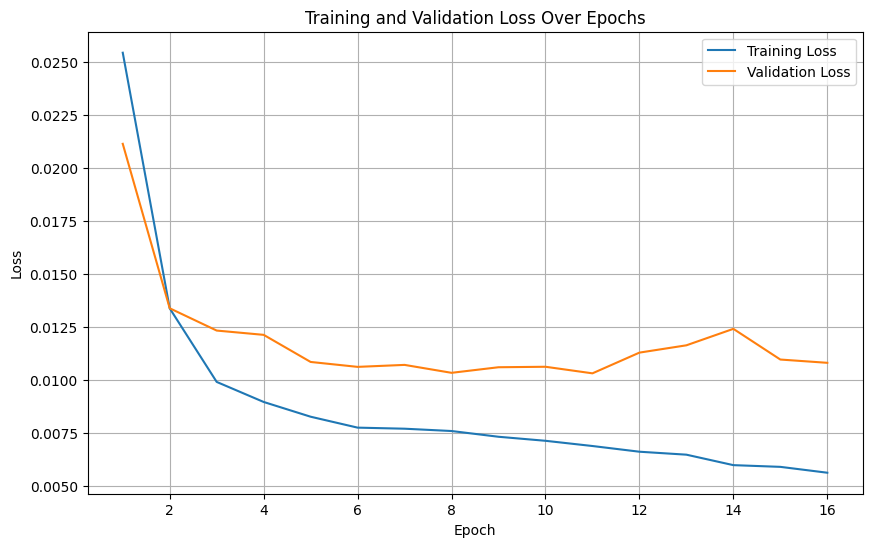

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt



# Data Preprocessing
X = data_df[['Avg Zenith Angle [degrees]', 'Avg Sun Flag', 'Avg Opaque Cloud Cover [%]', 'Avg Blue/Red_min',
        'Avg BRBG Total Cloud Cover [%]', 'Avg Azimuth Angle [degrees]', 'Avg Albedo (CMP11)',
        'Avg Tower Dew Point Temp [deg C]', 'Avg Total Cloud Cover [%]',
        'hour_of_day', 'day_of_year', 'month']]

y = data_df['y']

# Normalize the input features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the target variable using MinMaxScaler
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
# Ensure the data is not shuffled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Prepare sequences for the LSTM model
sequence_length = 12  # Adjust as needed
X_train_sequences = []
y_train_sequences = []

for i in range(sequence_length, len(X_train)):
    X_train_sequences.append(X_train[i - sequence_length:i])
    y_train_sequences.append(y_train[i])

X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)

# Define the LSTM model
model = keras.Sequential([
  keras.layers.LSTM(128, return_sequences=True, activation='tanh', input_shape=(sequence_length, X_train.shape[1])),
  keras.layers.LSTM(64, return_sequences=True, activation='tanh'),
  keras.layers.LSTM(32, activation='tanh'),
  keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Use early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(X_train_sequences, y_train_sequences,
                    epochs=50, batch_size=24,
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Prepare sequences for the test set
X_test_sequences = []

for i in range(sequence_length, len(X_test)):
    X_test_sequences.append(X_test[i - sequence_length:i])

X_test_sequences = np.array(X_test_sequences)

# Make predictions
y_pred = model.predict(X_test_sequences)

# Inverse transform the predictions to the original scale
y_pred = y_scaler.inverse_transform(y_pred)

# Inverse transform the training and testing target variables to the original scale
y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

# Calculate metrics on the original scale
mse = mean_squared_error(y_test[sequence_length:], y_pred)
mae = mean_absolute_error(y_test[sequence_length:], y_pred)
r2 = r2_score(y_test[sequence_length:], y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error on Original Scale: {mse}')
print(f'Mean Absolute Error on Original Scale: {mae}')
print(f'R-squared on Original Scale: {r2}')
print(f'RMSE on Original Scale: {rmse}')

# Extract training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot of the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


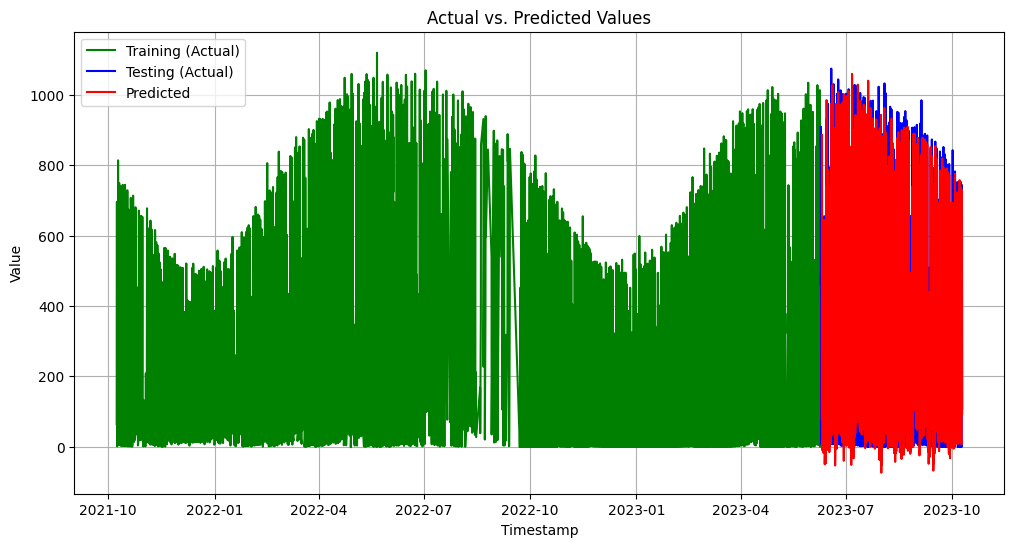

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have loaded your actual and predicted values earlier
# y_train contains training values, y_test contains testing values, and y_pred contains predicted values

# Plot the training values
plt.figure(figsize=(12, 6))
plt.plot(data_df.index[:len(y_train)], y_train, label='Training (Actual)', color='green')

# Plot the testing values
plt.plot(data_df.index[len(y_train):len(y_train) + len(y_test)], y_test, label='Testing (Actual)', color='blue')

# Plot the predicted values
plt.plot(data_df.index[len(y_train) + sequence_length:], y_pred, label='Predicted', color='red')

# Customize the plot
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## 5.Deep LSTM

Epoch 1/20
468/468 [==============================] - 28s 39ms/step - loss: 0.0292 - mae: 0.1245 - mse: 0.0292 - val_loss: 0.0158 - val_mae: 0.0868 - val_mse: 0.0158
Epoch 2/20
468/468 [==============================] - 17s 37ms/step - loss: 0.0115 - mae: 0.0716 - mse: 0.0115 - val_loss: 0.0165 - val_mae: 0.0946 - val_mse: 0.0165
Epoch 3/20
468/468 [==============================] - 17s 37ms/step - loss: 0.0102 - mae: 0.0665 - mse: 0.0102 - val_loss: 0.0120 - val_mae: 0.0737 - val_mse: 0.0120
Epoch 4/20
468/468 [==============================] - 18s 38ms/step - loss: 0.0093 - mae: 0.0620 - mse: 0.0093 - val_loss: 0.0115 - val_mae: 0.0714 - val_mse: 0.0115
Epoch 5/20
468/468 [==============================] - 17s 37ms/step - loss: 0.0090 - mae: 0.0601 - mse: 0.0090 - val_loss: 0.0108 - val_mae: 0.0689 - val_mse: 0.0108
Epoch 6/20
468/468 [==============================] - 18s 38ms/step - loss: 0.0087 - mae: 0.0582 - mse: 0.0087 - val_loss: 0.0105 - val_mae: 0.0668 - val_mse: 0.0105
Epoc

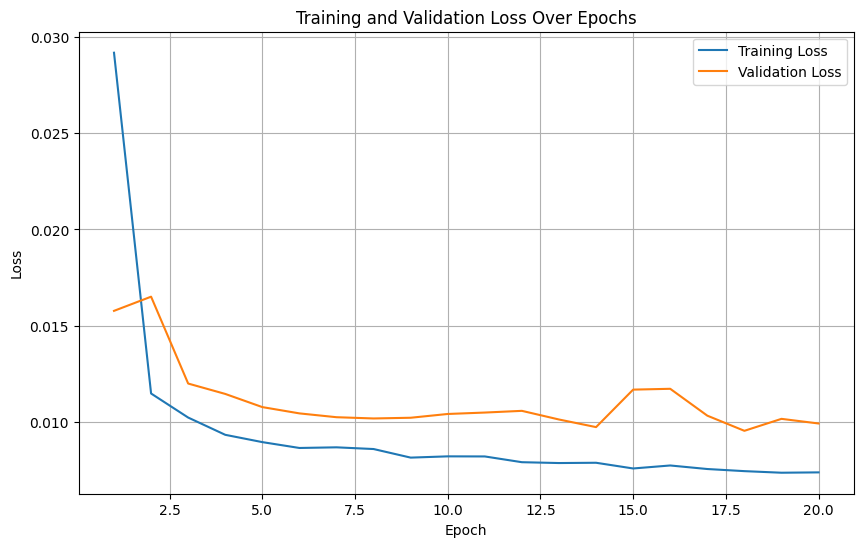

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your data from a CSV file or any other source
# df = pd.read_csv('your_data.csv')

# Data Preprocessing
X = data_df[['Avg Zenith Angle [degrees]', 'Avg Sun Flag', 'Avg Opaque Cloud Cover [%]', 'Avg Blue/Red_min',
        'Avg BRBG Total Cloud Cover [%]', 'Avg Azimuth Angle [degrees]', 'Avg Albedo (CMP11)',
        'Avg Tower Dew Point Temp [deg C]', 'Avg Total Cloud Cover [%]',
        'hour_of_day', 'day_of_year', 'month','Avg Global CMP22 (vent/cor) [W/m^2]_lagged_1']]

y = data_df['y']

# Normalize the input features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the target variable using MinMaxScaler
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
# Ensure the data is not shuffled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Prepare sequences for the LSTM model
sequence_length = 12  # Adjust as needed
X_train_sequences = []
y_train_sequences = []

for i in range(sequence_length, len(X_train)):
    X_train_sequences.append(X_train[i - sequence_length:i])
    y_train_sequences.append(y_train[i])

X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)

# Define the more complex LSTM model
model = keras.Sequential([
  keras.layers.LSTM(128, return_sequences=True, activation='sigmoid', input_shape=(sequence_length, X_train.shape[1])),
  keras.layers.LSTM(64, return_sequences=True, activation='sigmoid'),
  keras.layers.LSTM(32, return_sequences=True, activation='sigmoid'),
  keras.layers.LSTM(16, activation='sigmoid'),
  keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Use early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train_sequences, y_train_sequences,
                    epochs=20, batch_size=12,
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Prepare sequences for the test set
X_test_sequences = []

for i in range(sequence_length, len(X_test)):
    X_test_sequences.append(X_test[i - sequence_length:i])

X_test_sequences = np.array(X_test_sequences)

# Make predictions
y_pred = model.predict(X_test_sequences)

# Inverse transform the predictions to the original scale
y_pred = y_scaler.inverse_transform(y_pred)

# Inverse transform the training and testing target variables to the original scale
y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

# Calculate metrics on the original scale
mse = mean_squared_error(y_test[sequence_length:], y_pred)
mae = mean_absolute_error(y_test[sequence_length:], y_pred)
r2 = r2_score(y_test[sequence_length:], y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error on Original Scale: {mse}')
print(f'Mean Absolute Error on Original Scale: {mae}')
print(f'R-squared on Original Scale: {r2}')
print(f'RMSE on Original Scale: {rmse}')

# Extract training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot of the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
